# Time-stepping, good enough for meteorology

v1.101 1 December 2017, by Brian Fiedler

It is not easy to construct numerical schemes to forecast purely osillatory dynamical systems, for which the forecast faithfully repeats the oscillation cycle. In meteorology, it is not quite so important that forecast schemes have this property, as compared with solar system dynamics.  In solar system dynamics, if the forecast dropped the Earth into the Sun after several hundred orbits, the scheme would be unacceptable.  But in meteorology we could tolerate a scheme that cannot model a wave for a hundred oscillations, because weather has continuous sources of energy and dissipation.

Here we demonstrate a time-stepping forecast scheme that is good enough for the weather that we simulate in this course: third-order Adams-Bashforth.

In [1]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})
from IPython.core.display import HTML
import math
import matplotlib.pyplot as plt
%matplotlib inline
import urllib.request

In [2]:
HTML(urllib.request.urlopen('http://metrprof.xyz/metr4323.css').read().decode())
#HTML( open('metr4323.css').read() ) #or use this, if you have downloaded metr4233.css to your computer


# Lotka-Volterra Equations 
We need some equations to practice our numerical methods. Here are the *predator prey* equations, otherwise known as the [Lotka-Volterra equations](http://en.wikipedia.org/wiki/Lotka-Volterra_equation).  BTW, $x$ is for "rabbits" and $y$ is for "foxes".
$$
\frac{dx}{dt} = \alpha x - \beta x y
$$
$$
\frac{dy}{dt} = \delta x y  - \gamma y
$$
The wikipedia article can give you an explanation of the eating and dying processess that the equations intend to represent.

The fidelity of a model to conservation laws is important to examine.
Although $x$ and $y$ change with time, this quantity $V$ is conserved in the differential equations:
$$V = -\delta \, x + \gamma \, \ln(x) - \beta \, y + \alpha \, \ln(y)$$
By conserved we mean $\frac{dV}{dt}=0$, which you can have some fun proving.

In [3]:
# Specify the coefficients. I choose some very simple ones:
alpha = 1.
beta = 1.
delta = 1.
gamma = 1.

In [4]:
# This is the theoretically invariant (conserved) quantity:
def Vconserve(x,y):
    if x<=0 or y<=0: return None
    return gamma*math.log(x) - delta*x + alpha*math.log(y)- beta*y

In [5]:
# x is for rabbits, y is for foxes:
def dxdtlv(x,y):
    return alpha*x - beta*x*y 
def dydtlv(x,y):
    return delta*x*y - gamma*y

# Oscillator
The equations for a one-dimensional linear oscillator.   These should look familar. The spring constant is "1".
The equations have an analytical solution, and provide a test of the accuracy of our numerical methods.
$$\frac{dv}{dt} = - x$$

$$
\frac{dx}{dt} = v
$$
Conserved quantity is "Energy":
$$
E = x^2 + v^2
$$

In [6]:
def dxdto(x,v):
    return v
def dvdto(x,v):
    return -x
def Econserve(x,v):
    return x**2 + v**2


# Solving the ODE with an Adams-Bashforth finite-difference scheme

If we forecast with
$$
q(t+\Delta t) = q(t) + \frac{dq^*}{dt}(t)~ \Delta t 
$$
what is the best value to use for the $\frac{dq^*}{dt}(t)$?

An obvious choice is to use the value calculated from
the differential equation, meaning:
$$
\frac{dq^*}{dt}(t) = \frac{dq}{dt}(t) 
$$
The above the is *first-order Adams-Bashforth scheme*, which is equivalent to the Euler method.  But this simplest choice
is often not the best.

The "better" higher-order schemes blend  (make a weighted average) the values of $\frac{dq}{dt}(t)$ from several time steps.
The 2nd-order scheme:
$$
\frac{dq^*}{dt}(t) = \frac{3}{2} \frac{dq}{dt}(t) -  \frac{1}{2}\frac{dq}{dt}(t-\Delta t)
$$
The 3rd-order scheme:
$$
\frac{dq^*}{dt}(t) = \frac{23}{12} \frac{dq}{dt}(t) - \frac{16}{12} \frac{dq}{dt}(t -\Delta t) + \frac{5}{12}\frac{dq}{dt}(t-2\Delta t)
$$

Notice the coefficients add up to 1.  The function `ab_blend` calculates the $\frac{dq^*}{dt}$ based on the choice for the "order" of the scheme.

The coefficents for the 2nd-order scheme can be easily explained. 
$\frac{dq^*}{dt}(t)$ should ideally be an estimate, by extrapolation, appropriate for 
a time half way between the current time and the time to be forecasted:
$$
 \frac{dq}{dt}\left(t+\frac{1}{2}\Delta t\right) =   \frac{dq}{dt}(t) +
 \frac{1}{2} \Delta t \frac{ \frac{dq}{dt}(t) - \frac{dq}{dt}(t-\Delta t)}{\Delta t}
$$

The 3rd-order scheme is somewhat more difficult to derive. We will show a derivation in a later notebook.

For now, here is a reference for  [the higher order schemes](http://en.wikipedia.org/wiki/Linear_multistep_method#Adams.E2.80.93Bashforth_methods).

In [7]:
# dqdt is a list of the stored time derivatives for q, stored 
# in order from present to the past.  
def ab_blend(dqdt,order):
    if order==1:
        return dqdt[0]
    elif order==2:
        return 1.5*dqdt[0]-.5*dqdt[1]
    elif order==3:
        return (23*dqdt[0]-16*dqdt[1]+5*dqdt[2])/12.
    else:
        print("order", order ," not supported ")

In [8]:
# Test it. Let j be junk, and djdt to the list of time derivatives of j, at the current
# time step, previous time step and the time step before that:
djdt = [ 1.0, 1.1 , 1.4] 
ab_blend(djdt,3)

1.0333333333333332

In [9]:
# In stepper, we use the following scheme to roll a list.
# Note that djdt[:-1] is a slice that excludes the last item.
# Suppose the next forecast gives djdt=.9 
# Here is how we update our list of djdt:
djdt = [ .9 ] + djdt[:-1]
djdt

[0.9, 1.0, 1.1]

For arguments, `stepper` takes *initial* values of `x` and `y` and the names of two functions `f` and `g`. These functions return vales of derivatives for differential equations:
$$
\frac{dx}{dt} = f(x,y)
$$
and
$$
\frac{dy}{dt} = g(x,y)
$$
Also, a function name is supplied, for `cons(x,y)` that returns a metric about the solution. In the exampes here, we can compute a quantity that is conserved in the calculus solutions, to help assess the accuracy of the numerical solution.

In [10]:
def stepper(x,y,f,g,cons,time=0,tstop=50.,dt=1.,aborder=3,scheme=1):
    ta=[time]
    ya=[y]
    xa=[x]
    conservedThing = cons(x,y)
    ca=[conservedThing]
    nstep=0    
 
    dxdta=[0.,0.,0.]
    dydta=[0.,0.,0.]
 
    while time +0.5*dt < tstop : # stop at time closest to tstop
        nstep += 1
    # calculate time derivatives from the ODE:
        dxdt = f(x,y)
        dydt = g(x,y)

        if scheme == 1: #Adams-Bashforth 
            abnow = min(nstep,aborder) # first steps cannot use 3rd order Adams-Bashforth order
            # "roll" time derivatives, keep three, throw out the oldest.  
            dxdta = [dxdt] + dxdta[:-1]
            dydta = [dydt] + dydta[:-1] 
            # step forward in time, blending the time derivatives, as appropriate
            # for the order the Adams-Bashforth scheme specified by abnow
            x += dt * ab_blend(dxdta,abnow)
            y += dt * ab_blend(dydta,abnow)
            
        elif scheme ==2: #STUDENTS: implement predictor-corrector
            print('to be released soon!')
            return ta,xa,ya,ca
        
        else:
            print(scheme,' no plans to implement')
            return ta,xa,ya,ca
        
        time += dt

        ca.append( cons(x,y) )
        xa.append( x )
        ya.append( y )
        ta.append(time)

    return ta,xa,ya,ca

<hr>
# Repeatedly Start Here For Experiments
* You can execute some nifty experiments by simply tweaking the parameters in the cell below.
* Next,from the notebook menu for "Cell", select "Run All Below".

In [11]:
expt = 'lv'
#expt = 'osc'
abchoice = 2 # the order of the Adams-Bashforth scheme, 1 2 or 3
timestep = .2 # do experiments with .1 and .2
timescheme = 1 # 1->Adams-Bashforth, 2->Predictor corrector

In [12]:
if expt=='lv':
    times,xs,ys,cs = stepper(3.0,0.5,dxdtlv,dydtlv,Vconserve,
                dt=timestep,aborder=abchoice,scheme=timescheme)
elif expt=='osc':
    times,xs,ys,cs = stepper(1.0,0,dxdto,dvdto,Econserve,
                dt=timestep,aborder=abchoice,scheme=timescheme)
else:
    print(expt,'is not implemented')
print('Done. This many steps:', len(times))

Done. This many steps: 251


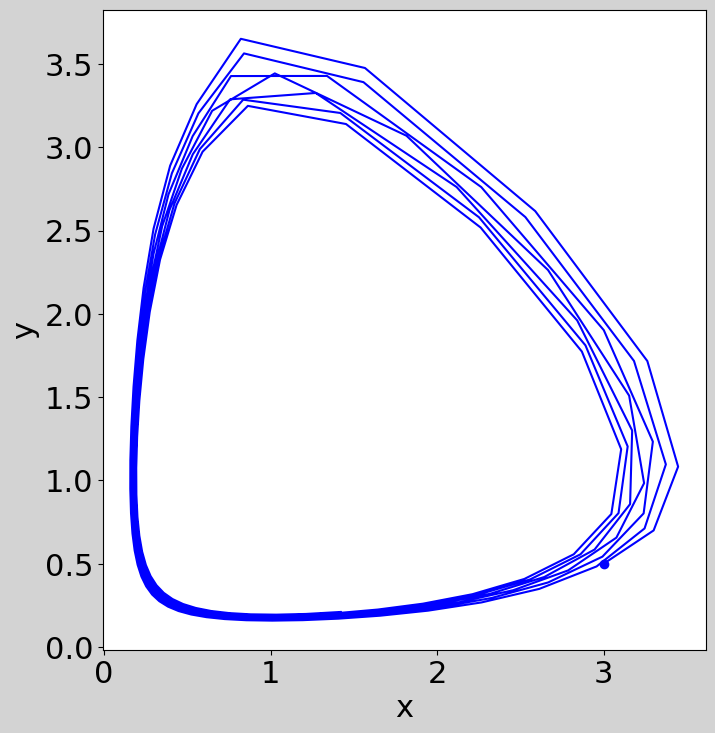

In [15]:
fig = plt.figure(facecolor='lightgrey',figsize=(8,8))
myaxes = fig.add_axes([0.1, 0.1, 0.8, 0.8],aspect='equal')
myaxes.plot(xs,ys,'b-')
myaxes.plot(xs[0],ys[0],'bo') # starts at dot
myaxes.set_facecolor("white")
myaxes.set_xlabel('x')
myaxes.set_ylabel('y');

In [ ]:
figb, axesb = plt.subplots() 
axesb.plot(times,xs,'b*-',label='$x$')
axesb.plot(times,ys,'g*-',label='$y$')
axesb.legend(loc=3)
axesb.set_xlabel('t')
axesb.set_xlim(0,50);

In [ ]:
figc, axesc = plt.subplots() 
axesc.plot(times,cs,'r*-')
axesc.set_title('The quantity that ideally is conserved \n note error may be large at first time step')
axesc.set_xlim(0,50);

In [ ]:
# We can compare with the exact solution, if easily known, as for 'osc'
if expt=='osc': # the oscillator
    import math
    xe = [math.cos(t) for t in times] # exact solution for x(t)
    error = [a-b for a,b in zip(xs,xe)] # a Python list comprehension
    print (len(error), len(times))
    
    figd, axesd = plt.subplots(nrows=2,ncols=1,figsize=(12,12)) 
    axesd[0].plot(times,xs,'b.-',label='forecasted')
    axesd[0].plot(times,xe,'m.-',label='exact')
    axesd[0].set_ylim(-1.5,1.5)
    axesd[0].set_xlim(0,50)
    axesd[0].legend(loc=3)
    theTitle = "timestep = %4.2f, abchoice = %d" % (timestep,abchoice)
    axesd[0].set_title(theTitle)
    
    axesd[1].plot(times,error,'r.-',label='forecast error')
    axesd[1].grid()
    err=1. # to be used in ylim
    if abchoice==3: err=.15
    if abchoice==3. and timestep<.15: err=.03
#    axesd[1].set_ylim(-err,err)
    axesd[1].set_xlim(0,round(times[-1]))
    axesd[1].legend(loc=3);

# Student tasks:

## 1. Experiments with Adams-Bashforth scheme

Experiment with `expt='osc'` and the four different combinations of:

* timestep = 0.1 or 0.2
* abchoice = 2 or 3

Note the magnitude of the error as defined by the linearly growing envelope to the plotted "forecast error".  We can quantify this error by the magnitude of the envelope at t=50. For example, this error magnitude is approximately 0.8 for `timestep=0.2` and `abchoice=2`. 

* What is the error magnitude for the other three experiments? 
* What quantitative evidence do you have that `abchoice=2` is "second-order accurate" and `abchoice=3` is "third-order accurate"? Hint: "second-order accurate" means the error is proportional to $(\Delta t)^2$ ...
* As $\Delta t$ becomes smaller, "third-order accurate" schemes are expected to be better than "second-order accurate" schemes.  A detailed theoretical analysis is required to quantify how much better, but that analysis is not provided here.  But do your experiments indicate that 3rd order is better than 2nd order? How much?  (Students can decide how to quantitatively state "how much better").

## 2. Implement the predictor-corrector scheme

Implement `scheme==2` in `stepper`. This should not be difficult.  This [short section in the wikipedia](https://en.wikipedia.org/wiki/Predictor%E2%80%93corrector_method#Example:_Euler_method_with_the_trapezoidal_rule) should show you how to do it.   Still need a hint? Check this out:  https://trinket.io/library/trinkets/2ad8c010ef .

Then demonstrate that the predictor-corrector scheme is second-order accurate for the oscillation equations. 


## 3. Truncation error in the solutions to the Lotka-Volterra Equations

BTW, the error we are referring to (the error from using a finite $\Delta t$ rather than an infinitesimal one)  is called *truncation error* (I believe). 

Now set `expt = 'lv'`.  Study the error in the **conserved metric** for the Lotka-Volterra Equations, and how it depends on $\Delta t$.  In your second-order schemes, is the error proportional to $(\Delta t)^2$?